In [1]:
# Anomaly detection using Isolation Forest

Starting Isolation Forest Trading Algorithm Backtest with Drawdown Protection...
Fetching data for BABA from 2020-01-01 to 2025-07-06...
Calculating anomaly scores using Isolation Forest...
Anomaly Score Statistics:
Min: -0.1149
Max: 0.2898
Mean: 0.2376
25th percentile: 0.2274
75th percentile: 0.2788
Dynamic Trading Thresholds:
Buy range: 0.0929 to 0.1874
Sell range: 0.2833 to 0.2862
Max Drawdown Limit: 30% from initial investment value

Running backtest...
BUY: 2020-02-04 at ₹222.88, Anomaly: 0.1575
SELL: 2020-02-06 at ₹220.90, Anomaly: 0.2846, Trade Return: -0.89%, Cumulative: -0.89%
BUY: 2020-03-09 at ₹197.66, Anomaly: 0.1874
SELL: 2020-03-20 at ₹181.30, Anomaly: 0.2842, Trade Return: -8.28%, Cumulative: -9.09%
BUY: 2020-03-24 at ₹185.75, Anomaly: 0.1308
SELL: 2020-04-09 at ₹196.37, Anomaly: 0.2854, Trade Return: 5.72%, Cumulative: -3.89%
BUY: 2020-05-01 at ₹194.48, Anomaly: 0.1850
SELL: 2020-05-27 at ₹201.18, Anomaly: 0.2860, Trade Return: 3.45%, Cumulative: -0.58%
BUY: 2020-05-29 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13540\3482960060.py:203: UserWarning: Portfolio dropped 32.45% from initial value (₹100,000 → ₹67,550), halted trading.
  warnings.warn(halt_reason, UserWarning)


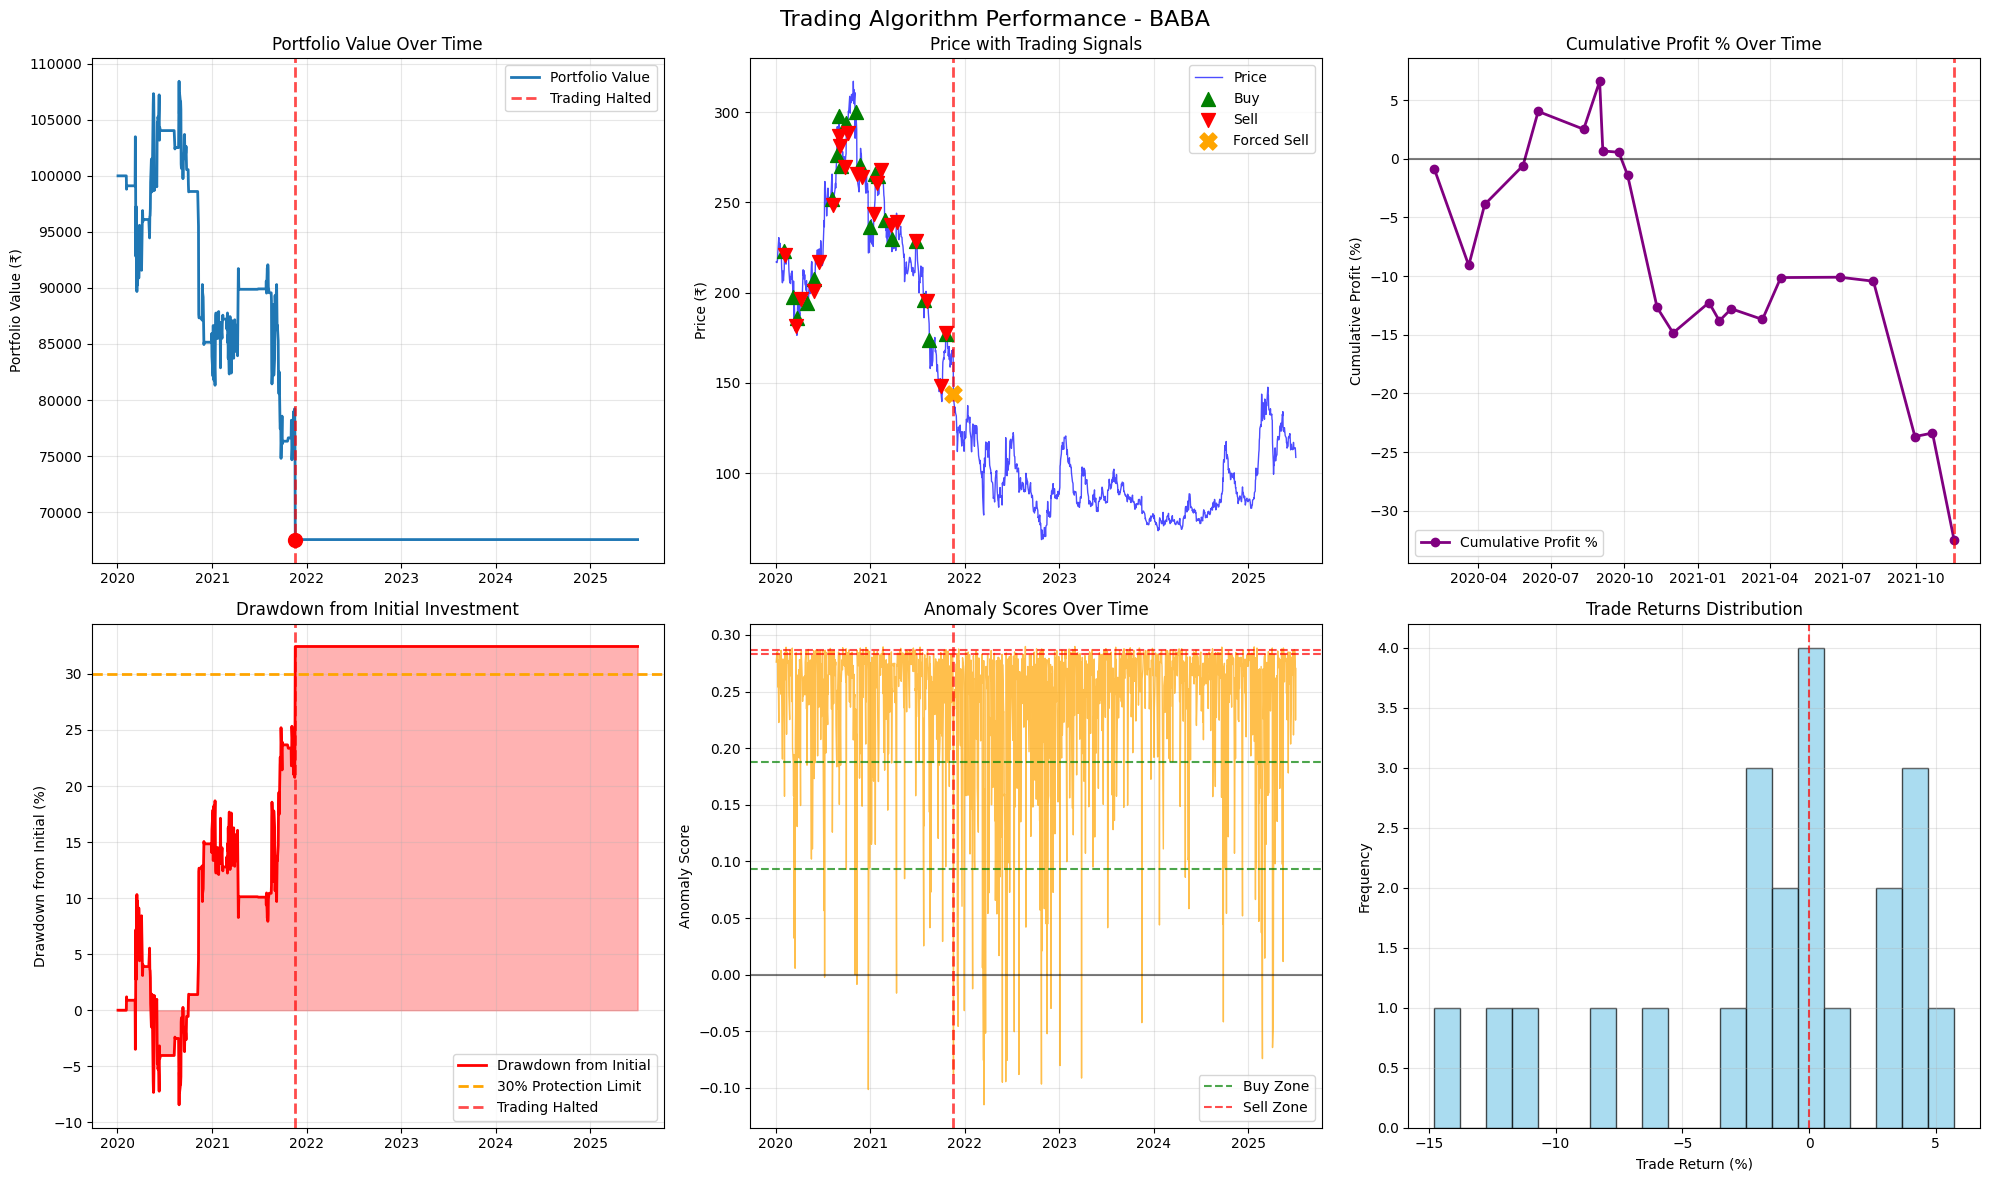


Results saved to CSV files

Final Note: Trading was halted due to maximum drawdown protection.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import requests
from datetime import datetime
import time
import warnings

def get_api_key(file_path):
    """Function to read API key from a file"""
    with open(file_path, 'r') as file:
        return file.read().strip()

def get_daily_data(symbol, start_date, end_date, api_key):
    """Fetch daily historical data for a single symbol from FMP API"""
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={start_date}&to={end_date}&apikey={api_key}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        
        if not data or 'historical' not in data:
            print(f"No data returned for {symbol} between {start_date} and {end_date}")
            return pd.DataFrame()
        
        historical_data = data['historical']
        
        if not historical_data:
            print(f"No historical data found for {symbol}")
            return pd.DataFrame()
        
        df = pd.DataFrame(historical_data)
        
        if not all(col in df.columns for col in ['date', 'open', 'high', 'low', 'close', 'volume']):
            print(f"Missing expected columns in data for {symbol}")
            return pd.DataFrame()
        
        df['date'] = pd.to_datetime(df['date'])
        df = df[['date', 'open', 'high', 'low', 'close', 'volume']]
        df['Symbol'] = symbol
        df = df.sort_values('date').reset_index(drop=True)
        
        return df
    else:
        print(f"Error fetching data for {symbol}: {response.status_code}")
        return pd.DataFrame()

def calculate_anomaly_scores(data):
    """Calculate anomaly scores using Isolation Forest"""
    # Calculate daily returns
    data['Returns'] = data['close'].pct_change()
    data.dropna(inplace=True)
    
    # Create a DataFrame with only the returns
    returns_df = data[['Returns']]
    
    # Initialize and fit the Isolation Forest model
    model = IsolationForest(contamination=0.02, random_state=42)
    model.fit(returns_df)
    
    # Predict anomalies and get decision function scores
    anomaly_scores = model.decision_function(returns_df)
    data['Anomaly_Score'] = anomaly_scores
    
    # Label anomalies (1 for anomaly, -1 for normal)
    data['Anomaly_Label'] = np.where(data['Anomaly_Score'] < 0, 1, -1)
    
    return data

def isolation_forest_trading_backtest(ticker, start_date, end_date, api_key_file, initial_investment=100000, max_drawdown_limit=30):
    """
    Enhanced trading algorithm using Isolation Forest anomaly detection with drawdown protection
    
    The algorithm will halt trading if the portfolio value drops by max_drawdown_limit% 
    from the initial investment (e.g., 30% drop from ₹100,000 = halt at ₹70,000)
    """
    
    # Get API key
    api_key = get_api_key(api_key_file)
    
    # Step 1: Initialize
    portfolio_value = initial_investment
    cash = initial_investment
    shares = 0
    position = None
    buy_price = 0
    buy_date = None
    
    # Drawdown protection variables
    trading_halted = False
    halt_date = None
    halt_reason = ""
    
    # Create empty list to hold trade metrics
    trades_list = []
    daily_portfolio_values = []
    
    # Step 2: Fetch Data and Calculate Anomalies
    print(f"Fetching data for {ticker} from {start_date} to {end_date}...")
    data = get_daily_data(ticker, start_date, end_date, api_key)
    
    if data.empty:
        print("Error: No data retrieved")
        return None, None, None
    
    print("Calculating anomaly scores using Isolation Forest...")
    data = calculate_anomaly_scores(data)
    
    # Initialize tracking variables
    peak_value = initial_investment
    max_drawdown = 0
    current_drawdown = 0
    
    # Analyze anomaly score distribution for better thresholds
    anomaly_scores = data['Anomaly_Score'].dropna()
    print(f"Anomaly Score Statistics:")
    print(f"Min: {anomaly_scores.min():.4f}")
    print(f"Max: {anomaly_scores.max():.4f}")
    print(f"Mean: {anomaly_scores.mean():.4f}")
    print(f"25th percentile: {anomaly_scores.quantile(0.25):.4f}")
    print(f"75th percentile: {anomaly_scores.quantile(0.75):.4f}")
    
    # Define dynamic thresholds based on data distribution
    # For Isolation Forest, lower scores indicate more anomalous behavior
    buy_threshold_low = anomaly_scores.quantile(0.05)   # Bottom 5% - strong anomalies for buying
    buy_threshold_high = anomaly_scores.quantile(0.15)  # Bottom 15%
    sell_threshold_low = anomaly_scores.quantile(0.85)  # Top 15% - normal behavior, time to sell
    sell_threshold_high = anomaly_scores.quantile(0.95) # Top 5%
    
    print(f"Dynamic Trading Thresholds:")
    print(f"Buy range: {buy_threshold_low:.4f} to {buy_threshold_high:.4f}")
    print(f"Sell range: {sell_threshold_low:.4f} to {sell_threshold_high:.4f}")
    print(f"Max Drawdown Limit: {max_drawdown_limit}% from initial investment value")
    
    # Step 3: Trading Logic
    print("\nRunning backtest...")
    
    for idx, row in data.iterrows():
        if pd.isna(row['Anomaly_Score']):
            continue
            
        date = row['date']
        anomaly_score = row['Anomaly_Score']
        current_price = row['close']
        
        # Calculate current portfolio value
        current_portfolio_value = cash + (shares * current_price)
        
        # Update peak value for tracking purposes
        if current_portfolio_value > peak_value:
            peak_value = current_portfolio_value
        
        # Calculate drawdown from INITIAL investment (not from peak)
        current_drawdown_from_initial = ((initial_investment - current_portfolio_value) / initial_investment) * 100
        
        # Also track traditional peak-to-trough drawdown for reporting
        peak_drawdown = ((peak_value - current_portfolio_value) / peak_value) * 100
        max_drawdown = max(max_drawdown, peak_drawdown)
        
        # CHECK FOR MAXIMUM DRAWDOWN LIMIT (from initial investment)
        if current_drawdown_from_initial >= max_drawdown_limit and not trading_halted:
            trading_halted = True
            halt_date = date
            halt_reason = f"Portfolio dropped {current_drawdown_from_initial:.2f}% from initial value (₹{initial_investment:,.0f} → ₹{current_portfolio_value:,.0f}), halted trading."
            
            # Force sell if holding position to limit further losses
            if position == 'long':
                sell_date = date
                sell_price = current_price
                
                # Calculate trade metrics for forced sell
                profit_percent = ((sell_price - buy_price) / buy_price) * 100
                profit_dollars = shares * (sell_price - buy_price)
                
                # Convert shares back to cash
                cash = shares * sell_price
                trade_shares = shares
                shares = 0
                position = None
                
                # Calculate cumulative profit percentage
                cumulative_profit_percent = ((cash - initial_investment) / initial_investment) * 100
                
                # Record forced trade
                trades_list.append({
                    'Buy Date': buy_date,
                    'Buy Price': round(buy_price, 2),
                    'Sell Date': sell_date,
                    'Sell Price': round(sell_price, 2),
                    'Shares': round(trade_shares, 2),
                    'Trade Return %': round(profit_percent, 2),
                    'Profit ₹': round(profit_dollars, 2),
                    'Portfolio Value': round(cash, 0),
                    'Cumulative Profit %': round(cumulative_profit_percent, 2),
                    'Max Drawdown %': round(max_drawdown, 2),
                    'Trade Type': 'FORCED SELL - Drawdown Protection'
                })
                
                print(f"FORCED SELL: {date.strftime('%Y-%m-%d')} at ₹{sell_price:.2f}, Trade Return: {profit_percent:.2f}%")
            
            # Issue warning
            warnings.warn(halt_reason, UserWarning)
            print(f"\n{'='*60}")
            print(f"WARNING: {halt_reason}")
            print(f"Trading halted on: {date.strftime('%Y-%m-%d')}")
            print(f"Portfolio value at halt: ₹{current_portfolio_value:,.0f}")
            print(f"Loss from peak: ₹{(peak_value - current_portfolio_value):,.0f}")
            print(f"{'='*60}\n")
        
        # Store daily portfolio value
        daily_portfolio_values.append({
            'Date': date,
            'Portfolio_Value': current_portfolio_value,
            'Drawdown_From_Peak': peak_drawdown,
            'Drawdown_From_Initial': current_drawdown_from_initial,
            'Anomaly_Score': anomaly_score,
            'Price': current_price,
            'Returns': row['Returns'],
            'Trading_Halted': trading_halted
        })
        
        # Skip trading logic if halted
        if trading_halted:
            continue
        
        # Buy logic: Strong anomaly (potential oversold condition)
        if buy_threshold_low <= anomaly_score <= buy_threshold_high and position is None and cash > 0:
            position = 'long'
            buy_price = current_price
            buy_date = date
            
            # Use all available cash to buy shares
            shares = cash / current_price
            cash = 0
            
            print(f"BUY: {date.strftime('%Y-%m-%d')} at ₹{current_price:.2f}, Anomaly: {anomaly_score:.4f}")
        
        # Sell logic: Normal behavior (potential overbought or profit-taking)
        elif sell_threshold_low <= anomaly_score <= sell_threshold_high and position == 'long':
            sell_date = date
            sell_price = current_price
            
            # Calculate trade metrics
            profit_percent = ((sell_price - buy_price) / buy_price) * 100
            profit_dollars = shares * (sell_price - buy_price)
            
            # Convert shares back to cash
            cash = shares * sell_price
            trade_shares = shares
            shares = 0
            position = None
            
            # Calculate cumulative profit percentage
            cumulative_profit_percent = ((cash - initial_investment) / initial_investment) * 100
            
            # Record trade
            trades_list.append({
                'Buy Date': buy_date,
                'Buy Price': round(buy_price, 2),
                'Sell Date': sell_date,
                'Sell Price': round(sell_price, 2),
                'Shares': round(trade_shares, 2),
                'Trade Return %': round(profit_percent, 2),
                'Profit ₹': round(profit_dollars, 2),
                'Portfolio Value': round(cash, 0),
                'Cumulative Profit %': round(cumulative_profit_percent, 2),
                'Max Drawdown %': round(max_drawdown, 2),
                'Trade Type': 'Normal'
            })
            
            print(f"SELL: {date.strftime('%Y-%m-%d')} at ₹{sell_price:.2f}, Anomaly: {anomaly_score:.4f}, Trade Return: {profit_percent:.2f}%, Cumulative: {cumulative_profit_percent:.2f}%")
    
    # Handle open position at end (only if not halted)
    if position == 'long' and not trading_halted:
        final_price = data['close'].iloc[-1]
        cash = shares * final_price
        shares = 0
        print(f"Closing open position at end: ₹{final_price:.2f}")
    
    # Create results DataFrames
    trades_df = pd.DataFrame(trades_list)
    daily_df = pd.DataFrame(daily_portfolio_values)
    
    # Calculate summary statistics
    final_portfolio_value = cash + (shares * data['close'].iloc[-1])
    total_return = ((final_portfolio_value - initial_investment) / initial_investment) * 100
    final_drawdown_from_initial = ((initial_investment - final_portfolio_value) / initial_investment) * 100
    
    # Calculate buy & hold return for comparison
    initial_price = data['close'].iloc[0]
    final_price = data['close'].iloc[-1]
    buy_hold_return = ((final_price - initial_price) / initial_price) * 100
    
    # Calculate additional metrics
    if not trades_df.empty:
        win_rate = (trades_df['Trade Return %'] > 0).mean() * 100
        avg_win = trades_df[trades_df['Trade Return %'] > 0]['Trade Return %'].mean()
        avg_loss = trades_df[trades_df['Trade Return %'] < 0]['Trade Return %'].mean()
        
        positive_trades = trades_df[trades_df['Trade Return %'] > 0]['Trade Return %'].sum()
        negative_trades = trades_df[trades_df['Trade Return %'] < 0]['Trade Return %'].sum()
        profit_factor = abs(positive_trades / negative_trades) if negative_trades != 0 else float('inf')
        
        # Calculate Sharpe ratio (assuming 252 trading days per year)
        if len(daily_df) > 1:
            daily_returns = daily_df['Portfolio_Value'].pct_change().dropna()
            sharpe_ratio = (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252)) if daily_returns.std() != 0 else 0
        else:
            sharpe_ratio = 0
    else:
        win_rate = avg_win = avg_loss = profit_factor = sharpe_ratio = 0
    
    # Print summary
    print("\n" + "="*60)
    print("BACKTEST SUMMARY")
    print("="*60)
    print(f"Ticker: {ticker}")
    print(f"Period: {start_date} to {end_date}")
    print(f"Initial Investment: ₹{initial_investment:,.0f}")
    print(f"Final Portfolio Value: ₹{final_portfolio_value:,.0f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Buy & Hold Return: {buy_hold_return:.2f}%")
    print(f"Excess Return: {total_return - buy_hold_return:.2f}%")
    print(f"Max Drawdown from Peak: {max_drawdown:.2f}%")
    print(f"Final Drawdown from Initial: {final_drawdown_from_initial:.2f}%")
    print(f"Drawdown Protection Limit: {max_drawdown_limit}% from initial value")
    
    if trading_halted:
        print(f"TRADING HALTED: {halt_reason}")
        print(f"Halt Date: {halt_date.strftime('%Y-%m-%d')}")
    
    print(f"Number of Trades: {len(trades_df)}")
    print(f"Win Rate: {win_rate:.1f}%")
    if not pd.isna(avg_win):
        print(f"Average Win: {avg_win:.2f}%")
    if not pd.isna(avg_loss):
        print(f"Average Loss: {avg_loss:.2f}%")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    
    # Add halt information to return
    halt_info = {
        'trading_halted': trading_halted,
        'halt_date': halt_date,
        'halt_reason': halt_reason
    }
    
    return trades_df, daily_df, data, halt_info

def plot_results(trades_df, daily_df, data, ticker, halt_info=None):
    """Create comprehensive visualization of trading results with halt indicator"""
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'Trading Algorithm Performance - {ticker}', fontsize=16)
    
    # 1. Portfolio value over time
    ax1 = axes[0, 0]
    ax1.plot(daily_df['Date'], daily_df['Portfolio_Value'], linewidth=2, label='Portfolio Value')
    
    # Mark halt point if applicable
    if halt_info and halt_info['trading_halted']:
        halt_date = halt_info['halt_date']
        halt_portfolio_value = daily_df[daily_df['Date'] == halt_date]['Portfolio_Value'].iloc[0]
        ax1.axvline(x=halt_date, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Trading Halted')
        ax1.scatter([halt_date], [halt_portfolio_value], color='red', s=100, zorder=5)
    
    ax1.set_title('Portfolio Value Over Time')
    ax1.set_ylabel('Portfolio Value (₹)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. Price with buy/sell signals
    ax2 = axes[0, 1]
    ax2.plot(data['date'], data['close'], linewidth=1, alpha=0.7, color='blue', label='Price')
    
    # Add buy/sell signals
    if not trades_df.empty:
        buy_dates = pd.to_datetime(trades_df['Buy Date'])
        buy_prices = trades_df['Buy Price']
        sell_dates = pd.to_datetime(trades_df['Sell Date'])
        sell_prices = trades_df['Sell Price']
        
        # Different markers for normal vs forced trades
        normal_trades = trades_df[trades_df.get('Trade Type', 'Normal') == 'Normal']
        forced_trades = trades_df[trades_df.get('Trade Type', 'Normal').str.contains('FORCED', na=False)]
        
        if not normal_trades.empty:
            ax2.scatter(pd.to_datetime(normal_trades['Buy Date']), normal_trades['Buy Price'], 
                       color='green', marker='^', s=100, label='Buy', zorder=5)
            ax2.scatter(pd.to_datetime(normal_trades['Sell Date']), normal_trades['Sell Price'], 
                       color='red', marker='v', s=100, label='Sell', zorder=5)
        
        if not forced_trades.empty:
            ax2.scatter(pd.to_datetime(forced_trades['Sell Date']), forced_trades['Sell Price'], 
                       color='orange', marker='X', s=150, label='Forced Sell', zorder=6)
    
    # Mark halt point
    if halt_info and halt_info['trading_halted']:
        ax2.axvline(x=halt_info['halt_date'], color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    ax2.set_title('Price with Trading Signals')
    ax2.set_ylabel('Price (₹)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Cumulative Profit % over time
    ax3 = axes[0, 2]
    if not trades_df.empty:
        ax3.plot(pd.to_datetime(trades_df['Sell Date']), trades_df['Cumulative Profit %'], 
                linewidth=2, marker='o', color='purple', label='Cumulative Profit %')
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        # Mark halt point
        if halt_info and halt_info['trading_halted']:
            ax3.axvline(x=halt_info['halt_date'], color='red', linestyle='--', linewidth=2, alpha=0.7)
        
        ax3.set_title('Cumulative Profit % Over Time')
        ax3.set_ylabel('Cumulative Profit (%)')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
    
    # 4. Drawdown from initial investment with 30% limit line
    ax4 = axes[1, 0]
    ax4.plot(daily_df['Date'], daily_df['Drawdown_From_Initial'], color='red', linewidth=2, label='Drawdown from Initial')
    ax4.fill_between(daily_df['Date'], daily_df['Drawdown_From_Initial'], 0, alpha=0.3, color='red')
    ax4.axhline(y=30, color='orange', linestyle='--', linewidth=2, label='30% Protection Limit')
    
    # Mark halt point
    if halt_info and halt_info['trading_halted']:
        ax4.axvline(x=halt_info['halt_date'], color='red', linestyle='--', linewidth=2, alpha=0.7, label='Trading Halted')
    
    ax4.set_title('Drawdown from Initial Investment')
    ax4.set_ylabel('Drawdown from Initial (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Anomaly scores
    ax5 = axes[1, 1]
    ax5.plot(data['date'], data['Anomaly_Score'], color='orange', alpha=0.7, linewidth=1)
    ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Add threshold lines if available
    anomaly_scores = data['Anomaly_Score'].dropna()
    buy_threshold_low = anomaly_scores.quantile(0.05)
    buy_threshold_high = anomaly_scores.quantile(0.15)
    sell_threshold_low = anomaly_scores.quantile(0.85)
    sell_threshold_high = anomaly_scores.quantile(0.95)
    
    ax5.axhline(y=buy_threshold_low, color='green', linestyle='--', alpha=0.7, label='Buy Zone')
    ax5.axhline(y=buy_threshold_high, color='green', linestyle='--', alpha=0.7)
    ax5.axhline(y=sell_threshold_low, color='red', linestyle='--', alpha=0.7, label='Sell Zone')
    ax5.axhline(y=sell_threshold_high, color='red', linestyle='--', alpha=0.7)
    
    # Mark halt point
    if halt_info and halt_info['trading_halted']:
        ax5.axvline(x=halt_info['halt_date'], color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    ax5.set_title('Anomaly Scores Over Time')
    ax5.set_ylabel('Anomaly Score')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Trade Returns Distribution
    ax6 = axes[1, 2]
    if not trades_df.empty:
        ax6.hist(trades_df['Trade Return %'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax6.axvline(x=0, color='red', linestyle='--', alpha=0.7)
        ax6.set_title('Trade Returns Distribution')
        ax6.set_xlabel('Trade Return (%)')
        ax6.set_ylabel('Frequency')
        ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Configuration
    ticker = 'BABA'
    start_date = '2020-01-01'
    end_date = '2025-07-06'
    api_key_file = "D:\\Monte_Carlo\\FMP_api_Key.txt"  # Update this path
    initial_investment = 100000
    max_drawdown_limit = 30  # 30% maximum drop from initial investment (not from peak)
    
    # Run backtest
    print("Starting Isolation Forest Trading Algorithm Backtest with Drawdown Protection...")
    print("="*60)
    
    trades_df, daily_df, data, halt_info = isolation_forest_trading_backtest(
        ticker, start_date, end_date, api_key_file, initial_investment, max_drawdown_limit
    )
    
    if trades_df is not None:
        print("\nDetailed Trade History:")
        print(trades_df.to_string(index=False))
        
        # Create visualizations
        plot_results(trades_df, daily_df, data, ticker, halt_info)
        
        # Save results to CSV
        trades_df.to_csv(f'{ticker}_trades_{start_date}_{end_date}.csv', index=False)
        daily_df.to_csv(f'{ticker}_daily_performance_{start_date}_{end_date}.csv', index=False)
        print(f"\nResults saved to CSV files")
        
        if halt_info['trading_halted']:
            print(f"\nFinal Note: Trading was halted due to maximum drawdown protection.")
    else:
        print("Backtest failed. Please check your data and API key.")